In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
from ae import Autoencoder
import matplotlib.pyplot as plt
from utils import display_examples, display_latents

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(), # Convert PIL image to tensor and scale to [0, 1]
])

## Downloading the MNIST dataset

In [10]:
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Download and load the MNIST test dataset
test_dataset = datasets.MNIST(
    root='./data',
    train=False,          # Load test set
    download=True,
    transform=transform
)

## Creating dataloaders and displaying sample image

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verify the download by printing some info
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Visualize a sample image
sample_image, sample_label = train_dataset[0]  # Get the first image and label
print(f"Sample image shape: {sample_image.shape}")  # Should be [1, 28, 28]
print(f"Sample label: {sample_label}")

Training set size: 60000
Test set size: 10000
Sample image shape: torch.Size([1, 28, 28])
Sample label: 5


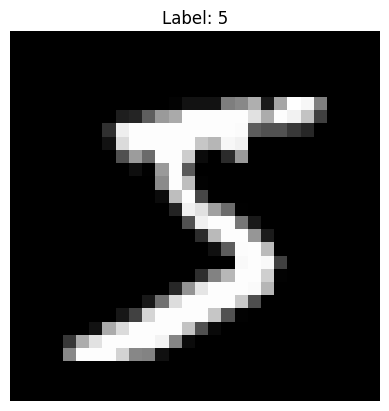

In [12]:
# Plot the sample image
plt.imshow(sample_image.squeeze(), cmap='gray')  # Squeeze removes the channel dim for plotting
plt.title(f"Label: {sample_label}")
plt.axis('off')  # Hide axes
plt.show()

## Declarations

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

convChannels = (1, 32, 64, 64, 64)
convKernels =   (3, 3, 2, 2)
convStrides =   (1, 1, 2, 2)
convPadding =   (1, 1, 0, 0)

# AutoEncoder
ae = Autoencoder(2, sample_image.shape, convChannels, convKernels, convStrides, convPadding).to(device)

# Loss function and optimizer
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)

## Main Training Loop

In [14]:
losses = []
iterations = []
max_epochs = 10

ae.train()
for epoch in range(max_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # Move images to GPU
        images = images.to(device)

        # Forward and backward pass
        optimizer.zero_grad()
        outputs = ae(images)
        latents = ae.latent # N x 2 tensor
        loss = mse_loss(outputs, images)
        loss.backward()
        optimizer.step()

        if i == 0:
            print(f"Epoch: {epoch}, Loss: {loss.detach()}")

torch.save(ae.state_dict(), './models/ae.pth')
print(f"Final Loss: {loss.detach()}")

Epoch: 0, Loss: 0.5713840126991272
Epoch: 1, Loss: 0.044560693204402924
Epoch: 2, Loss: 0.047512151300907135
Epoch: 3, Loss: 0.046170175075531006
Epoch: 4, Loss: 0.04625828191637993
Epoch: 5, Loss: 0.04042153060436249
Epoch: 6, Loss: 0.04081609100103378
Epoch: 7, Loss: 0.041859183460474014
Epoch: 8, Loss: 0.0421927310526371
Epoch: 9, Loss: 0.04231555014848709
Final Loss: 0.03863554447889328


## Displaying Examples

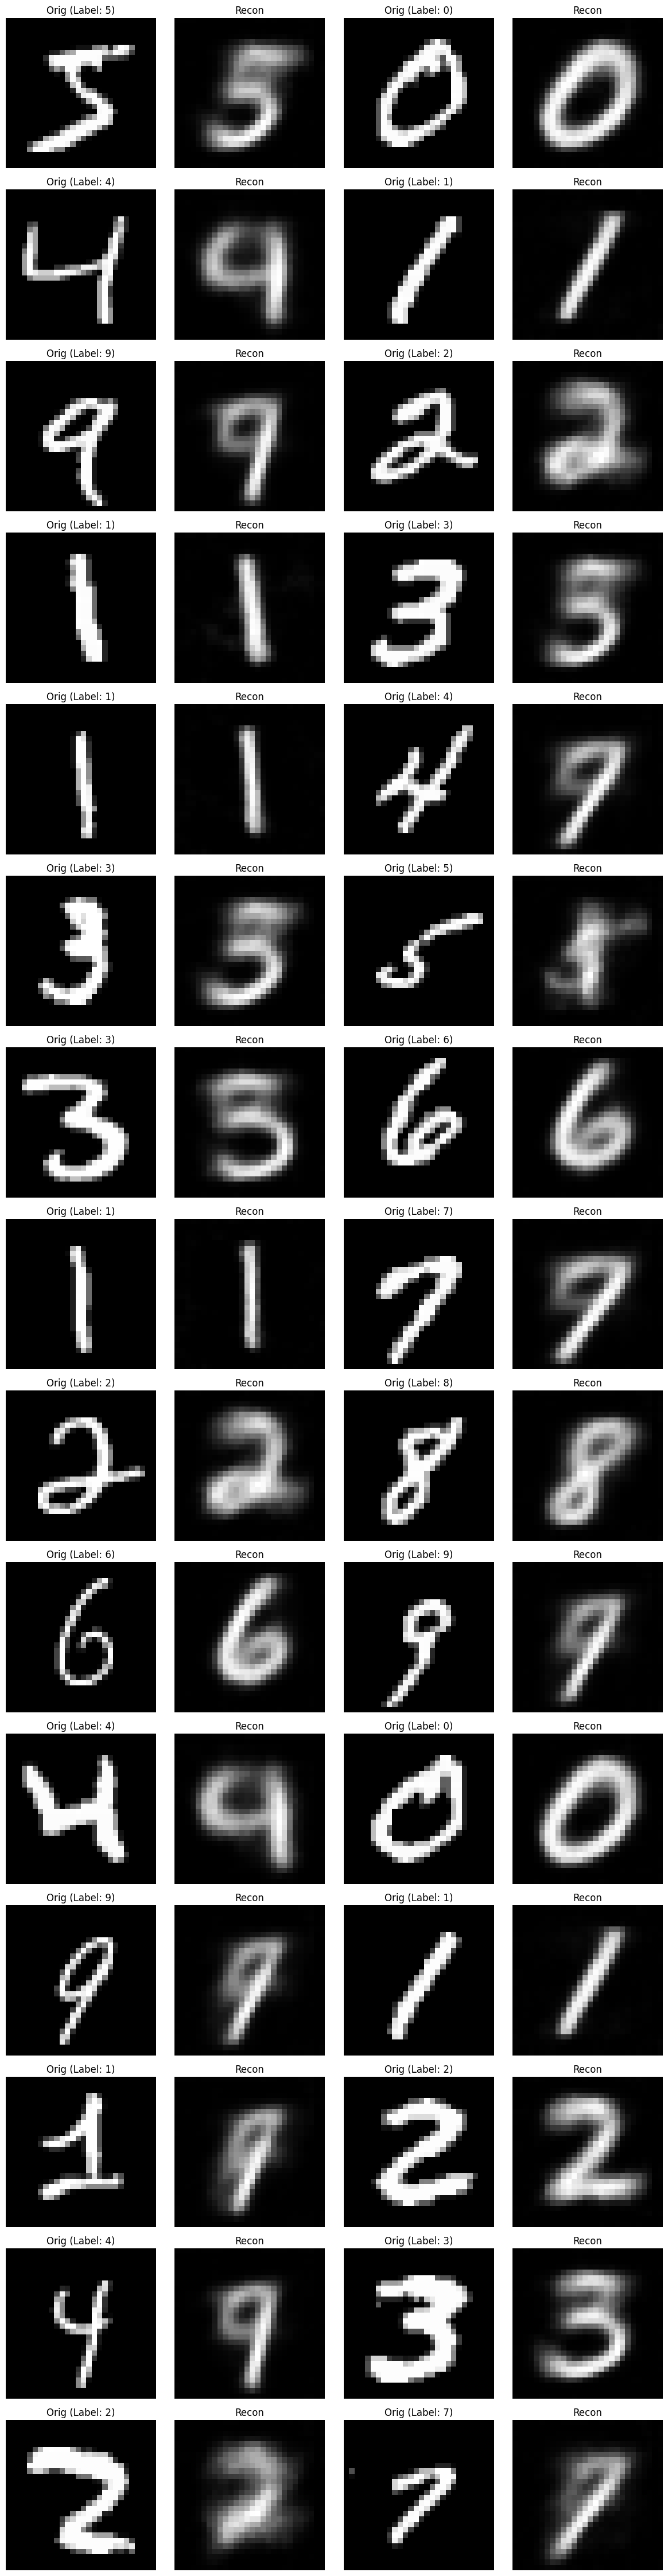

In [15]:
ae = ae = Autoencoder(2, sample_image.shape, convChannels, convKernels, convStrides, convPadding).to(device)
ae.load_state_dict(torch.load('models/ae.pth', weights_only=True))
display_examples(ae, train_dataset, device)

## Visualizing Latent Space

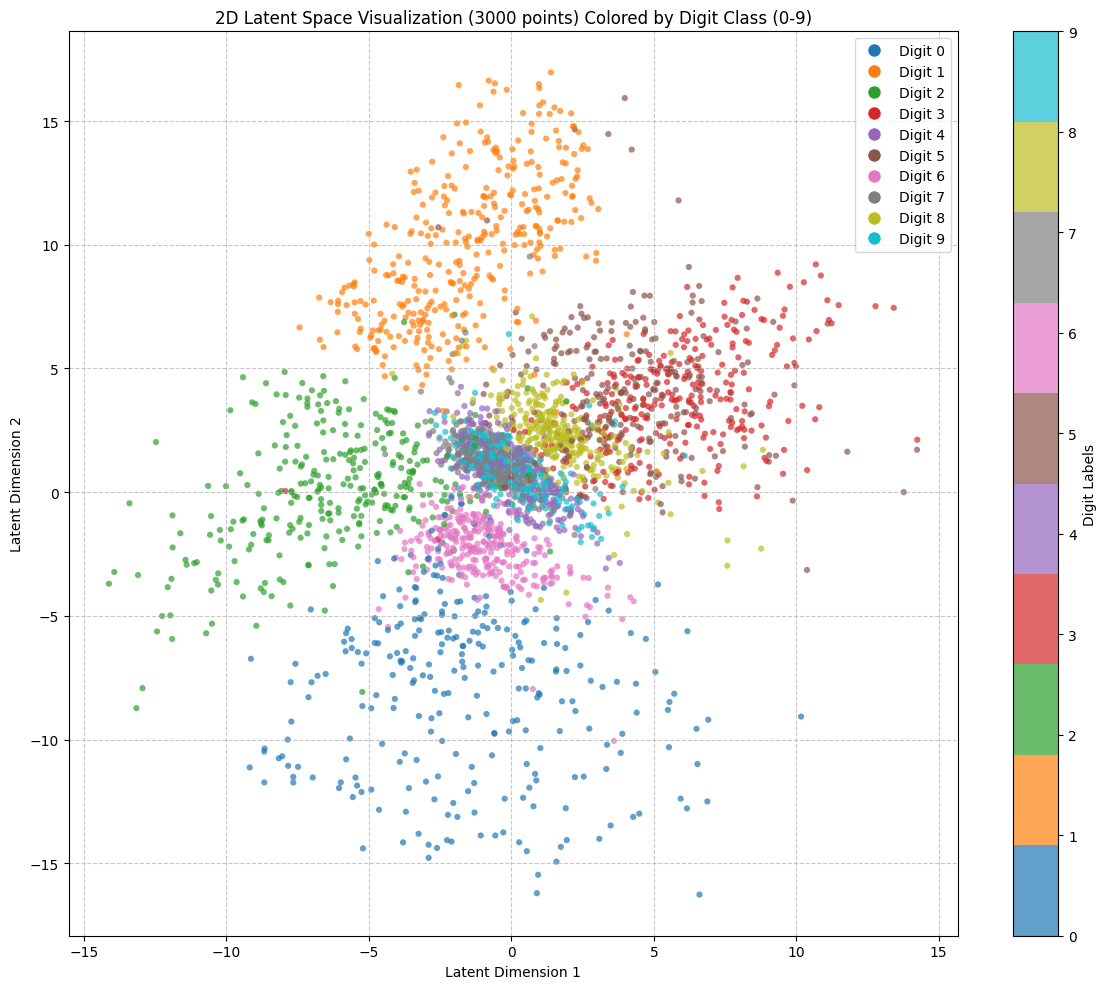

In [16]:
display_latents(ae, train_loader, device)

## Contrastive Loss
It feels intuitive that contrastive loss should increase performance. All of the space of R^2 exists for the latent space, yet there is a lot of overlap between different labels in the space.

However this might reduce reconstruction quality as reconstructing the correct number will be prioritized over encoding features of the drawing reducing fidelity.

In [17]:
def contrastive_loss(latents, labels, temperature=0.5):
    batch_size = latents.size(0)

    # Normalize the latents for cosine similarity
    latents = F.normalize(latents, p=2, dim=1)

    # Compute similarity matrix (N x N)
    sim_matrix = torch.matmul(latents, latents.T) / temperature

    # Create label mask
    labels = labels.unsqueeze(1)  # Shape: (N, 1)
    mask = torch.eq(labels, labels.T).float().to(latents.device)

    # Positive and negative masks
    pos_mask = mask - torch.eye(batch_size).to(latents.device)  # Exclude self-comparison

    # Logits: positive pairs vs all pairs
    exp_sim = torch.exp(sim_matrix)
    log_prob = sim_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True))

    # Contrastive loss: average over positive pairs
    contrastive_loss = -(log_prob * pos_mask).sum() / pos_mask.sum()
    return contrastive_loss

In [18]:
# AutoEncoder
aeWithContrastiveLoss = Autoencoder(2, sample_image.shape, convChannels, convKernels, convStrides, convPadding).to(device)
optimizerWithContrastiveLoss = torch.optim.Adam(aeWithContrastiveLoss.parameters(), lr=0.001)

## Training Loop With Contrastive Loss

In [19]:
lambda_contrastive = 1  # Weighting factor for contrastive loss

losses = []
iterations = []
max_epochs = 10

aeWithContrastiveLoss.train()
for epoch in range(max_epochs):
    for i, (images, labels) in enumerate(train_loader):

        # Move to GPU
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizerWithContrastiveLoss.zero_grad()
        outputs = aeWithContrastiveLoss(images)
        latents = aeWithContrastiveLoss.latent  # N x 2 tensor

        # Compute losses
        reconstruction_loss = mse_loss(outputs, images)
        cont_loss = contrastive_loss(latents, labels)

        loss = reconstruction_loss + lambda_contrastive * cont_loss

        # Backward pass
        loss.backward()
        optimizerWithContrastiveLoss.step()

        if i == 0:
            print(f"Epoch: {epoch}, Recon Loss: {reconstruction_loss.item():.4f}, Contrastive Loss: {cont_loss.item():.4f}, Total Loss: {loss.item():.4f}")

torch.save(aeWithContrastiveLoss.state_dict(), './models/aeContrastive.pth')
print(f"Final Loss: {loss.detach()}")

Epoch: 0, Recon Loss: 0.3959, Contrastive Loss: 4.6799, Total Loss: 5.0759
Epoch: 1, Recon Loss: 0.0541, Contrastive Loss: 3.3149, Total Loss: 3.3690
Epoch: 2, Recon Loss: 0.0542, Contrastive Loss: 3.0912, Total Loss: 3.1454
Epoch: 3, Recon Loss: 0.0512, Contrastive Loss: 3.1006, Total Loss: 3.1518
Epoch: 4, Recon Loss: 0.0528, Contrastive Loss: 3.1133, Total Loss: 3.1661
Epoch: 5, Recon Loss: 0.0522, Contrastive Loss: 3.2313, Total Loss: 3.2835
Epoch: 6, Recon Loss: 0.0478, Contrastive Loss: 3.0498, Total Loss: 3.0976
Epoch: 7, Recon Loss: 0.0511, Contrastive Loss: 3.0349, Total Loss: 3.0861
Epoch: 8, Recon Loss: 0.0534, Contrastive Loss: 3.1800, Total Loss: 3.2334
Epoch: 9, Recon Loss: 0.0500, Contrastive Loss: 3.1386, Total Loss: 3.1885
Final Loss: 2.4417824745178223


## Displaying Examples with Contrastive Loss

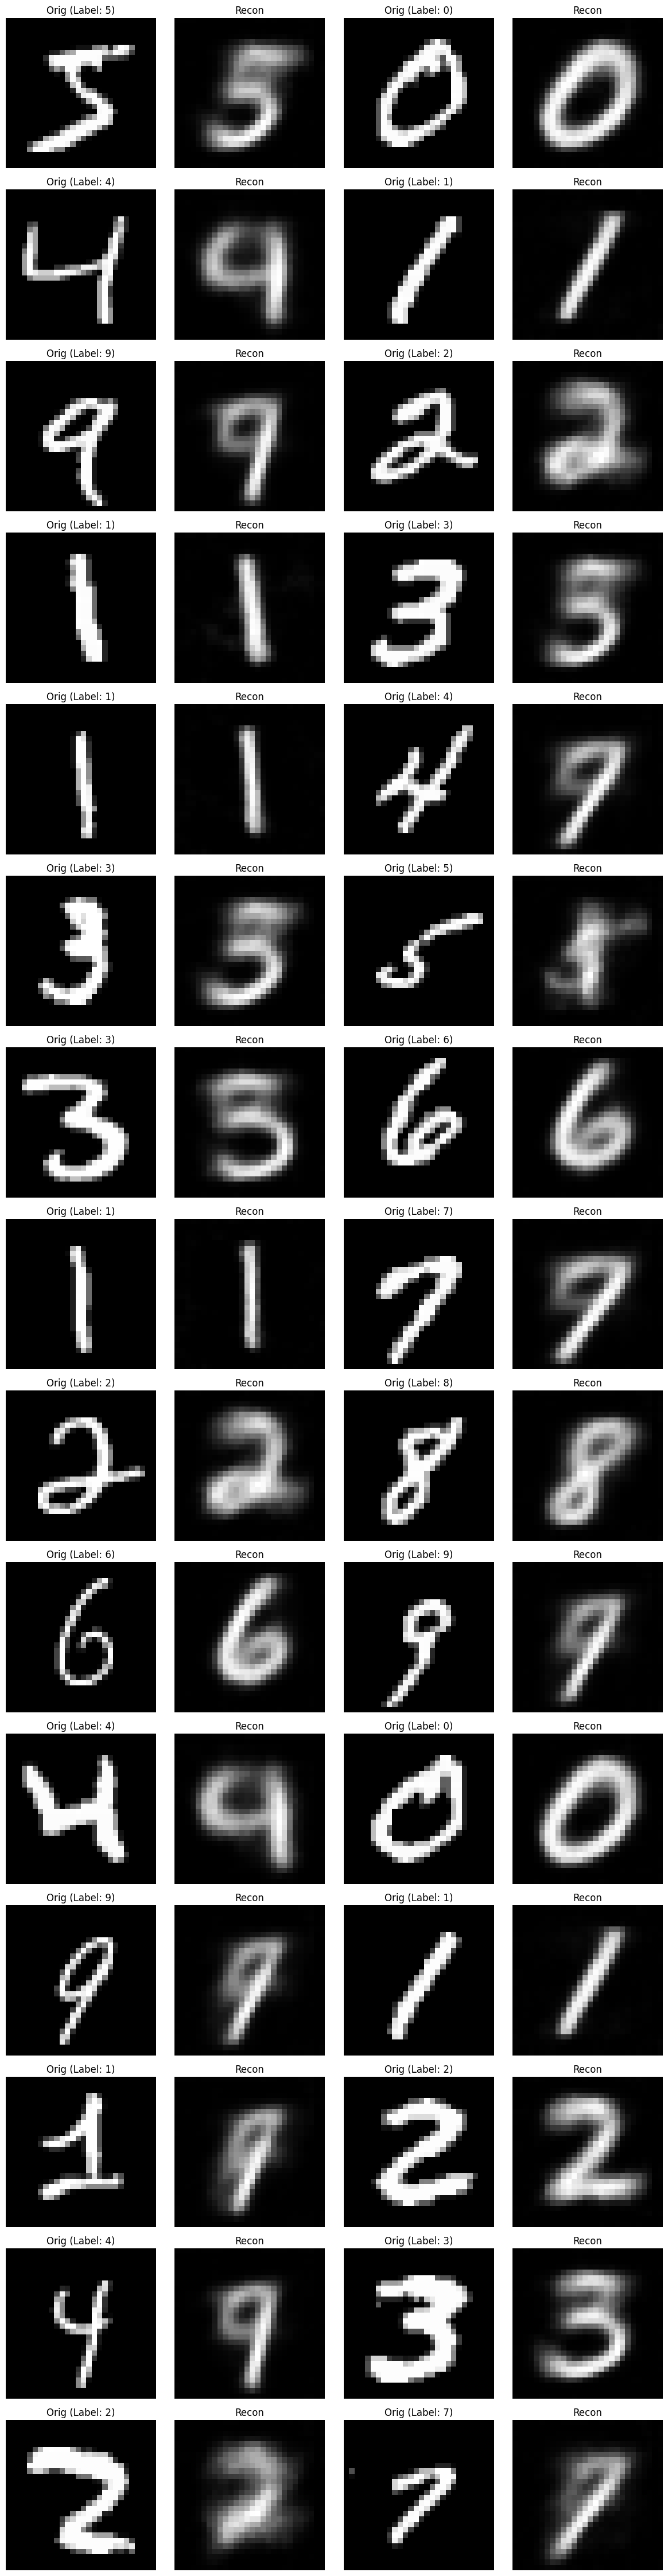

In [20]:
aeWithContrastiveLoss = Autoencoder(2, sample_image.shape, convChannels, convKernels, convStrides, convPadding).to(device)
aeWithContrastiveLoss.load_state_dict(torch.load('./models/aeContrastive.pth', weights_only=True))
display_examples(ae, train_dataset, device)

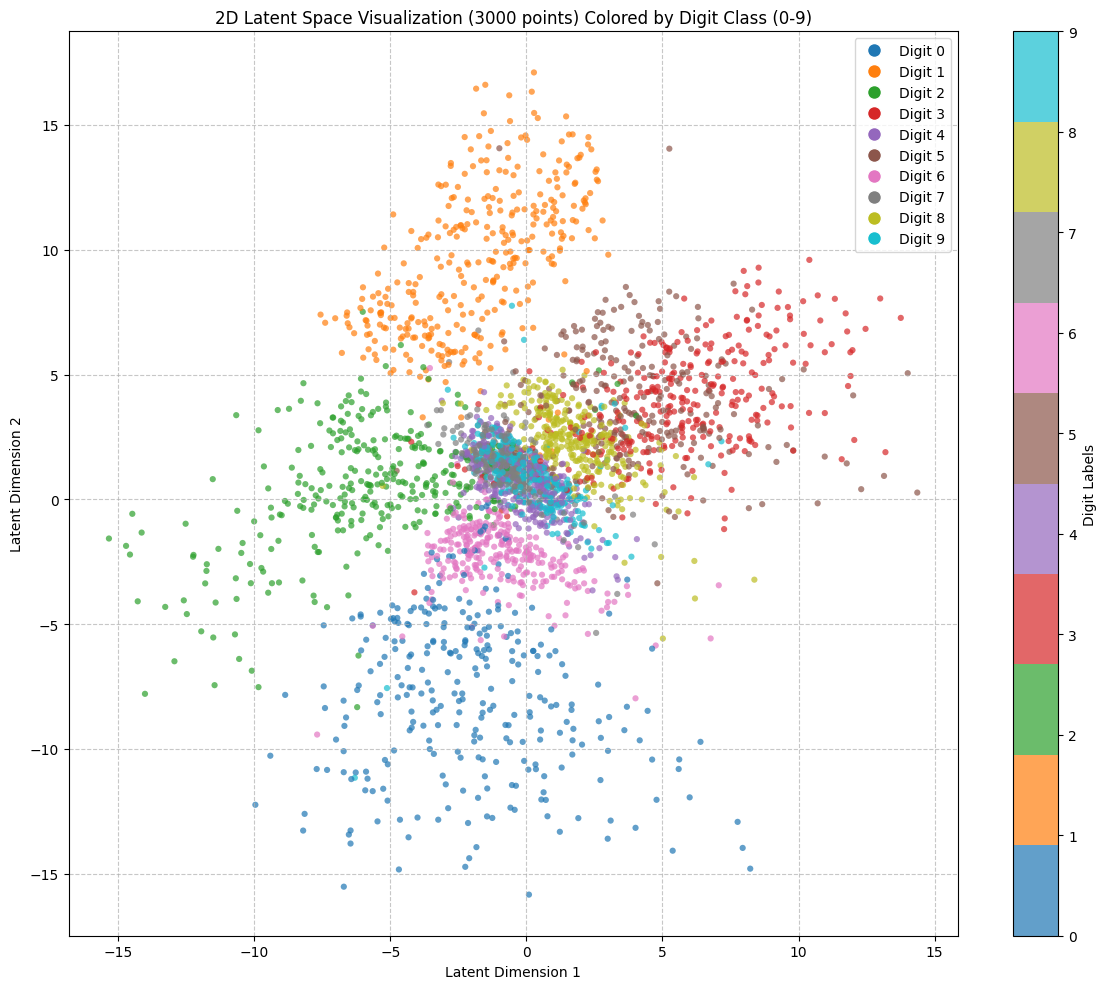

In [21]:
display_latents(ae, train_loader, device)